In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
meta = pd.read_csv("D:\mycodes\LIDC-IDRI-Preprocessing\data\Meta\meta_info.csv")
meta.head()

,patient_id,nodule_no,slice_no,original_image,mask_image,malignancy,is_cancer,is_clean,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,slice_thickness
0,1,0,0,0001_NI000_slice000,0001_MA000_slice000,5,True,False,5,1,6,4,4,3,5,5,2.5
1,1,0,1,0001_NI000_slice001,0001_MA000_slice001,5,True,False,5,1,6,4,4,3,5,5,2.5
2,1,0,2,0001_NI000_slice002,0001_MA000_slice002,5,True,False,5,1,6,4,4,3,5,5,2.5
3,1,0,3,0001_NI000_slice003,0001_MA000_slice003,5,True,False,5,1,6,4,4,3,5,5,2.5
4,1,0,4,0001_NI000_slice004,0001_MA000_slice004,5,True,False,5,1,6,4,4,3,5,5,2.5


In [3]:
DATA_PATH = "D:/mycodes/LIDC-IDRI-Preprocessing/data"

def get_orig_path(row):
    return "%s/Image/LIDC-IDRI-%04d/%s.npy" % (DATA_PATH, row.patient_id, row.original_image)

    
def get_mask_path(row):
    return "%s/Mask/LIDC-IDRI-%04d/%s.npy" % (DATA_PATH, row.patient_id, row.mask_image)

In [6]:
row = meta.iloc[0] # pd.Series
orig = np.load(get_orig_path(row)) # numpy.ndarray 512x512
mask = np.load(get_mask_path(row)) # numpy.ndarray 512x512
orig.shape, mask.shape

((512, 512), (512, 512))

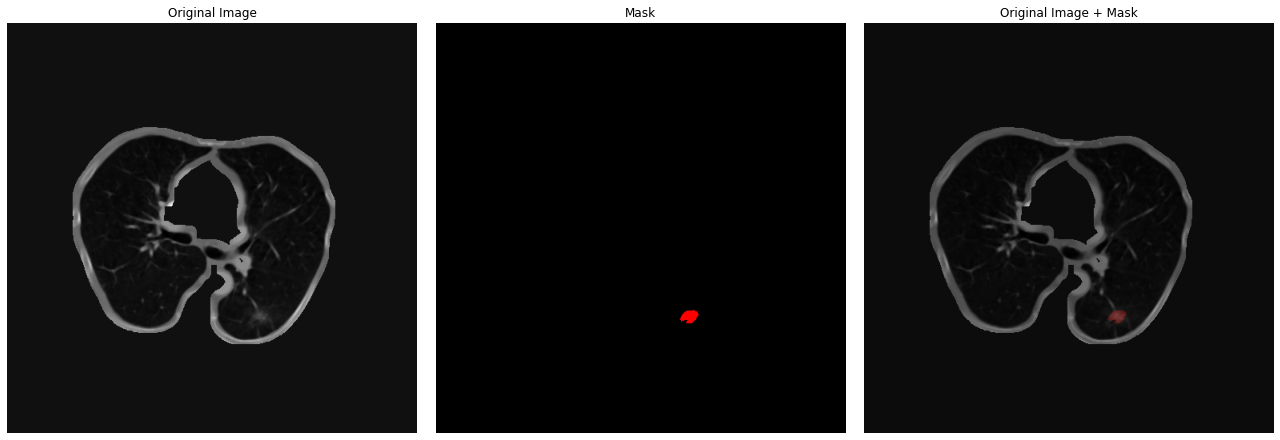

In [7]:
# 创建一个颜色映射，只在掩膜为1的区域显示颜色
colored_mask = np.zeros((*orig.shape, 3))  # 生成一个RGB图像
colored_mask[mask == 1] = [1, 0, 0]  # 将掩膜区域设置为红色

# 设置画布大小和子图
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1行3列

# 展示原始图像
axs[0].imshow(orig, cmap='gray')  # 使用灰度显示原始图像
axs[0].axis('off')  # 隐藏坐标轴
axs[0].set_title("Original Image")

# 展示掩膜
axs[1].imshow(colored_mask)  # 仅展示掩膜，标注区域为红色
axs[1].axis('off')  # 隐藏坐标轴
axs[1].set_title("Mask")

# 展示叠加的图像
axs[2].imshow(orig, cmap='gray')  # 原始图像
axs[2].imshow(colored_mask, alpha=0.25)  # 掩膜叠加
axs[2].axis('off')  # 隐藏坐标轴
axs[2].set_title("Original Image + Mask")

plt.tight_layout()  # 调整布局
plt.show()

In [18]:
def get_nodule_slices(meta, patient_id, nodule_no):
    tmp_df:pd.DataFrame = meta[(meta['patient_id'] == patient_id) & (meta['nodule_no'] == nodule_no)]
    orig_list = []
    mask_list = []
    for _, row in tmp_df.iterrows():
        orig_list.append(get_orig_path(row))
        mask_list.append(get_mask_path(row))
    return orig_list, mask_list

In [20]:
orig_list, mask_list = get_nodule_slices(meta, 1, 0)

interactive(children=(IntSlider(value=0, description='Slice', max=7), Output()), _dom_classes=('widget-interac…

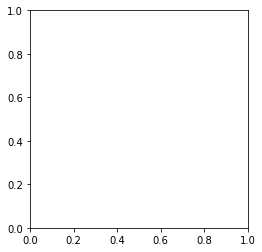

In [22]:
slider = widgets.IntSlider(value=0, min=0, max=len(orig_list)-1, step=1, description='Slice')

# 创建展示函数
def show_image(index):
    plt.imshow(orig_list[index], cmap='gray')  # 根据需要调整色图
    plt.axis('off')
    plt.title(f'Slice {index}')
    plt.show()

# 绑定滑块事件
widgets.interactive(show_image, index=slider)